### Modeling 시작

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings("ignore")

### Dataset 준비
사전에 미리 전처리 해둔 데이터셋을 기반으로 학습한다.

In [2]:
dataset = pd.read_csv(r"./test.csv")
dataset

,title,content,views,label
0,출첵,출첵,7,0
1,출석합니다,출석합니다좋은밤 되세요,7,0
2,투명페인트는 뭘로 지워야할까요,붓펜 작업중 엉뚱한 곳에 묻어서굳었네요,79,0
3,전동 압분 한번 사봤습니다,거의 열흘 전에 택배 온거 같은데이제 꺼내보네요ㅋㅋㅋ 크기에 한번 놀라고 헤드 부...,340,1
4,역시 차는 광이 나야,무슨 차던 제대로 번쩍이는 차에 한 번 더 눈길이 갑니다ㅎㅎ유일하게 꾸준히 재밌게 ...,461,1
...,...,...,...,...
3030,이와키로 내린 커피,한 없는 기다림 후의 짧은 기쁨 기쁨을 되새김질하며 또다시 긴 기다림 인생과 커피는...,166,1
3031,flowmeter에 위치선정,아침에 삽질한번하고 엄청나게 공부하고있네요 ㅎㅎㅎㅎㅎ 좋은 삽질인듯 플로우메터 위치...,280,1
3032,퇴근길,기흥에서 일산까지 퇴근길 햄버거 생각나 간만에 녹사평역 근처 썬더버거 들러 버거 하...,198,1
3033,서울공업사 왔다가는중 입니다,클리외님과 에소프릭님에 도움으로 알게되서 편하게 찾아갔네요사장님은 바로 알아체시더군...,245,1


In [3]:
dataset['label'].value_counts() # 라벨값이 어느정도 균등하게 분포되어 있는 모습

label
1    1521
0    1514
Name: count, dtype: int64

In [4]:
dataset.head()

,title,content,views,label
0,출첵,출첵,7,0
1,출석합니다,출석합니다좋은밤 되세요,7,0
2,투명페인트는 뭘로 지워야할까요,붓펜 작업중 엉뚱한 곳에 묻어서굳었네요,79,0
3,전동 압분 한번 사봤습니다,거의 열흘 전에 택배 온거 같은데이제 꺼내보네요ㅋㅋㅋ 크기에 한번 놀라고 헤드 부...,340,1
4,역시 차는 광이 나야,무슨 차던 제대로 번쩍이는 차에 한 번 더 눈길이 갑니다ㅎㅎ유일하게 꾸준히 재밌게 ...,461,1


### Feature engineering

In [5]:
dataset.head()

,title,content,views,label
0,출첵,출첵,7,0
1,출석합니다,출석합니다좋은밤 되세요,7,0
2,투명페인트는 뭘로 지워야할까요,붓펜 작업중 엉뚱한 곳에 묻어서굳었네요,79,0
3,전동 압분 한번 사봤습니다,거의 열흘 전에 택배 온거 같은데이제 꺼내보네요ㅋㅋㅋ 크기에 한번 놀라고 헤드 부...,340,1
4,역시 차는 광이 나야,무슨 차던 제대로 번쩍이는 차에 한 번 더 눈길이 갑니다ㅎㅎ유일하게 꾸준히 재밌게 ...,461,1


### Dataset 분할

In [6]:
train_data, test_data = train_test_split(dataset, test_size=0.25, random_state=0) # 7.5 : 2.5 비율로 분할한다.

In [7]:
print(train_data.shape)

(2276, 4)


In [8]:
print(test_data.shape)

(759, 4)


### 라벨값 분포 확인

각 라벨 간에 균형은 알맞은지, 편향적 샘플링이 되지는 않는지 확인한다.

In [9]:
train_data['label'].value_counts()

label
1    1138
0    1138
Name: count, dtype: int64

In [10]:
test_data['label'].value_counts()

label
1    383
0    376
Name: count, dtype: int64

### Stop words 정의

In [11]:
# 불용어 정의
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = """아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 
입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 
그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 
그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 
향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 
여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 
보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 
단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 
몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 
반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 
에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 
관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 
어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 
어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 
그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 
어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 
의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 
즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 
이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 
했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 
없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 
해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 
어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 
버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 
앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 
서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 
않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 
그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 
윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 
않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 
오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 
이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 
연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 
에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 
이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 
부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 
결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 
총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 
륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 
같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 
씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 
전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓""".replace("\n", "").split(" ")

### 토큰분리

title과 content의 토큰 분리를 별도로 실시한다.

In [12]:
mecab = Mecab(r"C:\mecab\mecab-ko-dic") 

train_data['tokenized_title'] = train_data['title'].apply(mecab.morphs)
train_data['tokenized_title'] = train_data['tokenized_title'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized_title'] = test_data['title'].apply(mecab.morphs)
test_data['tokenized_title'] = test_data['tokenized_title'].apply(lambda x: [item for item in x if item not in stopwords])

In [13]:
train_data['tokenized_content'] = train_data['content'].apply(mecab.morphs)
train_data['tokenized_content'] = train_data['tokenized_content'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized_content'] = test_data['content'].apply(mecab.morphs)
test_data['tokenized_content'] = test_data['tokenized_content'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
train_data

,title,content,views,label,tokenized_title,tokenized_content
351,인천 선학역 인근 세차장 추천바래요,일하러 인천왓는데세차를 벌써 달째못하고잇네요게러지나 실내세차장이 있을까요차가커서 기...,194,1,"[인천, 선학역, 인근, 세차장, 추천, 바래, 요]","[러, 인천, 왓, 는데, 세차, 벌써, 달째, 못, 고, 잇, 요게, 러지, 실내..."
838,앗 회원님 차 발견,아까 아부지 차 세차하고 가는길에 회원님 차 발견했네요 길거리에서는 처음 마주친지라...,623,1,"[회원, 님, 차, 발견]","[아까, 아부지, 차, 세차, 고, 는, 길, 회원, 님, 차, 발견, 했, 네요,..."
2980,즐거운 하루 보내고 계신지요,벌써 금요일입니다어떻게 하루하루가 지나가는지 모를 정도로빠르게 지나감을 느끼네요즐거...,161,1,"[즐거운, 하루, 보내, 고, 계신, 지요]","[벌써, 금요일, 입니다, 하루하루, 지나가, 는지, 모를, 빠르, 게, 지나감, ..."
1385,전달,빵빵 고정틀 무리 전달 왔어요 ㅋㅋㄱㄲㅋ막자랍니당 빵빵빠또 그리면서 넘넘 재밌었답니...,174,1,[전달],"[빵빵, 고정, 틀, 무리, 전달, 왔, 어요, ㅋㅋ, ㄱ, ㄲㅋ막자랍니당, 빵빵,..."
1665,앱 인증합니다,사진그림으로 저장이 안되네요ㅠ,8,0,"[앱, 인증, 합니다]","[사진, 그림, 저장, 네요, ㅠ]"
...,...,...,...,...,...,...
763,반갑습니다,아래 양식에 맞게 가입인사를 작성하여 주시면 감사하겠습니다 닉네임 창원II...,15,0,[반갑],"[아래, 양식, 맞, 게, 가입, 인사, 작성, 시, 면, 감사, 겠, 닉네임, 창..."
835,간만에 신상쓰기,오랜만에 평일 퇴근후 세차장 가는길 항상 그래왔던 것처럼 칼퇴 ㅋㅋ세차장 갈때는 항...,499,1,"[간만에, 신상, 쓰, 기]","[오랜만, 평일, 퇴근, 세, 차장, 는, 길, 항상, 그래왔, 던, 처럼, 칼, ..."
1653,모동숲 질문,몇년전에 튀동숲하다가 이번에 스위치 구매해서 모동숲 시작하는데모동숲에도 지노 있나요...,70,0,"[모동, 숲, 질문]","[튀, 동, 숲, 다가, 스위치, 구매, 해서, 모동, 숲, 시작, 는, 모동, 숲..."
2607,베르크 폼 미쳤다,코만단테하고 베르크 같이 왔습니다 ㅎㅎ,618,1,"[베르크, 폼, 미쳤, 다]","[코만, 단테, 베르크, 왔, ㅎㅎ]"


In [15]:
unPopular1 = np.hstack(train_data[train_data.label == 0]['tokenized_title'].values)
popular1 = np.hstack(train_data[train_data.label == 1]['tokenized_title'].values)
unPopular2 = np.hstack(train_data[train_data.label == 0]['tokenized_content'].values)
popular2 = np.hstack(train_data[train_data.label == 1]['tokenized_content'].values)

In [16]:
unpopular_word_count = Counter(unPopular1) # 시퀀스를 토큰화했을 때 가장 자주 등장하는 20개의 토큰을 확인한다.
unpopular_word_count2 = Counter(unPopular2) 
print(unpopular_word_count.most_common(20))
print(unpopular_word_count2.most_common(20))

[('숲', 269), ('모동', 211), ('세요', 190), ('안녕', 189), ('가입', 173), ('인사', 156), ('사요', 83), ('드립니다', 79), ('질문', 76), ('동', 56), ('합니다', 40), ('토크', 34), ('반갑', 34), ('리조트', 32), ('튀', 30), ('어요', 28), ('후기', 27), ('아요', 27), ('인증', 26), ('나눔', 26)]
[('는', 2352), ('고', 1004), ('은', 933), ('필수', 824), ('숲', 604), ('시', 601), ('가입', 583), ('홈', 572), ('도', 536), ('게', 445), ('바리스타', 437), ('카페', 422), ('면', 402), ('리조트', 398), ('사용', 362), ('커피', 354), ('세요', 345), ('분', 342), ('해', 333), ('w', 322)]


In [17]:
popular_word_count = Counter(popular1)
popular_word_count2 = Counter(popular2)
print(popular_word_count.most_common(20))
print(popular_word_count2.most_common(20))

[('는', 98), ('세차', 76), ('질문', 73), ('네요', 58), ('은', 53), ('도', 51), ('고', 45), ('나요', 44), ('분', 44), ('커피', 43), ('추천', 39), ('해', 35), ('요', 34), ('사용', 32), ('게', 32), ('했', 32), ('비', 32), ('숲', 32), ('드립니다', 32), ('님', 31)]
[('는', 3140), ('고', 2550), ('은', 1848), ('도', 1346), ('게', 945), ('네요', 840), ('는데', 834), ('시', 804), ('해', 791), ('면', 722), ('입니다', 647), ('했', 621), ('합니다', 588), ('다', 577), ('었', 485), ('사용', 462), ('세차', 461), ('기', 458), ('세요', 455), ('니', 449)]


인기 게시글 제목의 평균 길이 : 5.3743409490333915
비인기 게시글 제목의 평균 길이 : 3.169595782073814


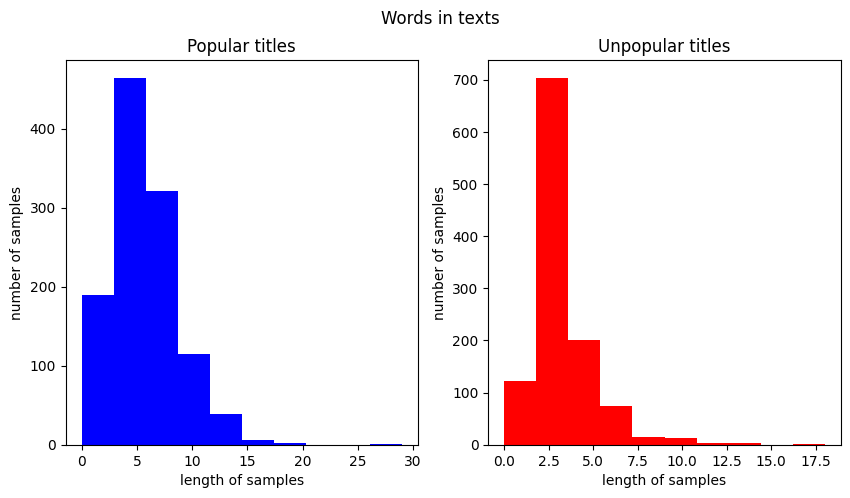

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized_title'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Popular titles')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('인기 게시글 제목의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized_title'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Unpopular titles')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('비인기 게시글 제목의 평균 길이 :', np.mean(text_len))
plt.show()

인기 게시글 본문의 평균 길이 : 84.51933216168717
비인기 게시글 본문의 평균 길이 : 50.89718804920914


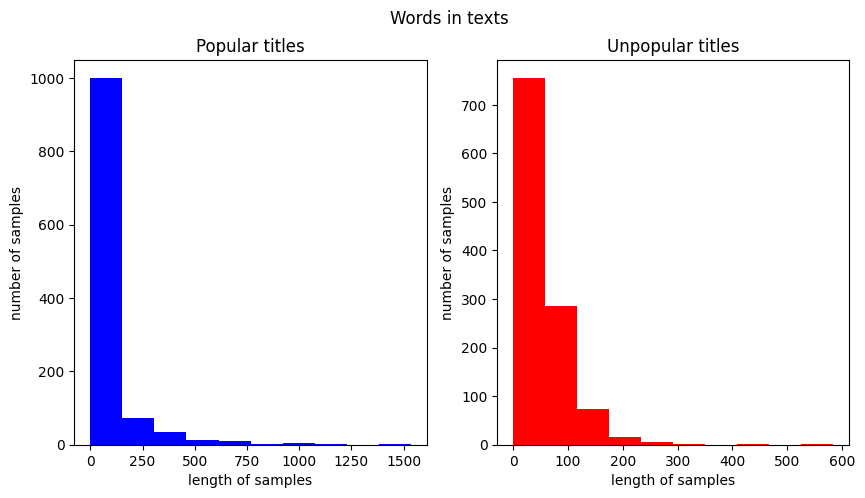

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized_content'].map(lambda x: len(x))
ax1.hist(text_len, color='blue')
ax1.set_title('Popular titles')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('인기 게시글 본문의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized_content'].map(lambda x: len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Unpopular titles')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('비인기 게시글 본문의 평균 길이 :', np.mean(text_len))
plt.show()

In [20]:
X_train = train_data[['tokenized_title', 'tokenized_content']]
y_train = train_data['label']
X_test= test_data[['tokenized_title', 'tokenized_content']]
y_test = test_data['label']

### 정수형 인코딩
본문과 제목에 대한 인코더를 별도로 정의한다.

In [21]:
tokenizer_for_title = Tokenizer()
tokenizer_for_title.fit_on_texts(X_train.iloc[:, 0].values)

In [22]:
tokenizer_for_content = Tokenizer()
tokenizer_for_content.fit_on_texts(X_train.iloc[:, 1].values)

In [23]:
threshold = 2
total_cnt_of_title = len(tokenizer_for_title.word_index) # 단어의 수
rare_cnt_of_title = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq_of_title = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq_of_title = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_for_title.word_counts.items():
    total_freq_of_title = total_freq_of_title + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt_of_title = rare_cnt_of_title + 1
        rare_freq_of_title = rare_freq_of_title + value

print('제목 단어 집합(vocabulary)의 크기 :',total_cnt_of_title)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt_of_title))
print("제목 단어 집합에서 희귀 단어의 비율:", (rare_cnt_of_title / total_cnt_of_title)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq_of_title / total_freq_of_title)*100)

제목 단어 집합(vocabulary)의 크기 : 2768
등장 빈도가 1번 이하인 희귀 단어의 수: 1727
제목 단어 집합에서 희귀 단어의 비율: 62.391618497109825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.762007610819705


In [24]:
threshold = 2
total_cnt_of_content = len(tokenizer_for_content.word_index) # 단어의 수
rare_cnt_of_content = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq_of_content = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq_of_content = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_for_content.word_counts.items():
    total_freq_of_content = total_freq_of_content + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt_of_content = rare_cnt_of_content + 1
        rare_freq_of_content = rare_freq_of_content + value

print('본문 단어 집합(vocabulary)의 크기 :',total_cnt_of_content)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt_of_content))
print("본문 단어 집합에서 희귀 단어의 비율:", (rare_cnt_of_content / total_cnt_of_content)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq_of_content / total_freq_of_content)*100)

본문 단어 집합(vocabulary)의 크기 : 14270
등장 빈도가 1번 이하인 희귀 단어의 수: 6976
본문 단어 집합에서 희귀 단어의 비율: 48.885774351786964
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.526813061309245


단어의 등장 횟수가 1회인 단어들은 정수 인코딩 대상에서 제외시킨다. 단, zero padding 토큰과 oov 토큰을 고려하여 +2를 해준다.

In [25]:
vocab_size_of_title = total_cnt_of_title - rare_cnt_of_title + 2
print('단어 집합의 크기 :',vocab_size_of_title)

단어 집합의 크기 : 1043


In [26]:
vocab_size_of_content = total_cnt_of_content - rare_cnt_of_content + 2
print('단어 집합의 크기 :',vocab_size_of_content)

단어 집합의 크기 : 7296


In [27]:
# 정수 인코딩

tokenizer_for_title = Tokenizer(vocab_size_of_title, oov_token = 'OOV') 
tokenizer_for_title.fit_on_texts(X_train.iloc[:, 0].values)
X_train['tokenized_title'] = tokenizer_for_title.texts_to_sequences(X_train.iloc[:, 0].values)
X_test['tokenized_title'] = tokenizer_for_title.texts_to_sequences(X_test.iloc[:, 0].values)

In [28]:
# 정수 인코딩

tokenizer_for_content = Tokenizer(vocab_size_of_content, oov_token = 'OOV') 
tokenizer_for_content.fit_on_texts(X_train.iloc[:, 1].values)
X_train['tokenized_content'] = tokenizer_for_content.texts_to_sequences(X_train.iloc[:, 1].values)
X_test['tokenized_content'] = tokenizer_for_content.texts_to_sequences(X_test.iloc[:, 1].values)

제목의 최대 길이 : 29
제목의 평균 길이 : 4.271968365553603


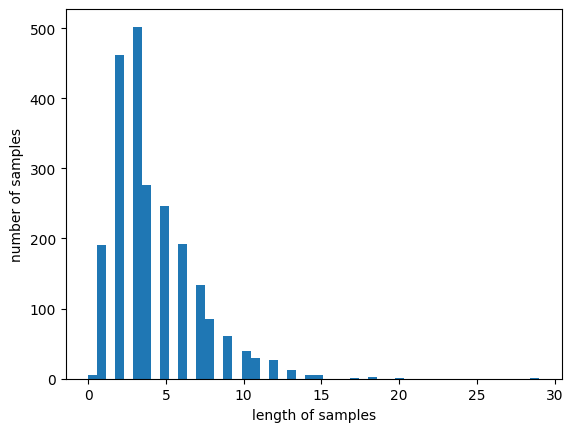

In [29]:
print('제목의 최대 길이 :',max(len(title) for title in X_train.iloc[:, 0].values))
print('제목의 평균 길이 :',sum(map(len, X_train.iloc[:, 0].values))/len(X_train.iloc[:, 0].values))
plt.hist([len(title) for title in X_train.iloc[:, 0].values], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

본문의 최대 길이 : 1534
본문의 평균 길이 : 67.70826010544816


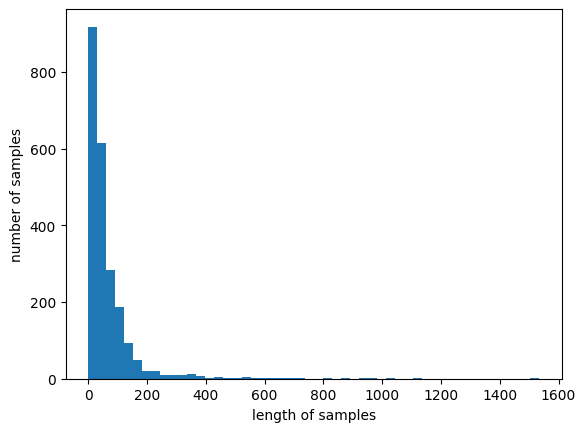

In [30]:
print('본문의 최대 길이 :',max(len(content) for content in X_train.iloc[:, 1].values))
print('본문의 평균 길이 :',sum(map(len, X_train.iloc[:, 1].values))/len(X_train.iloc[:, 1].values))
plt.hist([len(content) for content in X_train.iloc[:, 1].values], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
              count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

제목의 최대길이 = 약 30글자  
본문의 최대길이 = 약 1000자

In [32]:
max_len_title = 30
below_threshold_len(max_len_title, X_train.iloc[:, 0])

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [33]:
max_len_content = 1000
below_threshold_len(max_len_content, X_train.iloc[:, 1])

전체 샘플 중 길이가 1000 이하인 샘플의 비율: 99.78031634446397


패딩 시 각 글자의 최대 길이에 맞는 패딩을 별도로 진행한 후, 열 방향으로 결합한다.

> 총 데이터 건수 : 3035, 0.25의 비율로 test셋을 분할했기에 train의 총 건수는 2276<br>
> padded_sequence_of_title's shape = (2276, 30) ➡️ 30길이로 패딩하기 때문<br>
> padded_sequence_of_content's shape = (2276, 1000) ➡️ 1000길이로 패딩하기 때문<br>

따라서 훈련 데이터의 형상은 (2276, 1030)을 가지게 된다.

In [34]:
padded_title_of_train = pad_sequences(X_train['tokenized_title'].values, maxlen=max_len_title)
padded_content_of_train = pad_sequences(X_train['tokenized_content'].values, maxlen=max_len_content)
X_train = np.concatenate((padded_title_of_train, padded_content_of_train), axis = 1)

padded_title_of_test = pad_sequences(X_test['tokenized_title'].values, maxlen=max_len_title)
padded_content_of_test = pad_sequences(X_test['tokenized_content'].values, maxlen=max_len_content)
X_test = np.concatenate((padded_title_of_test, padded_content_of_test), axis = 1)


In [35]:
X_train.shape
X_train

array([[   0,    0,    0, ...,    4, 1212,   11],
       [   0,    0,    0, ..., 3057, 3058,  103],
       [   0,    0,    0, ...,  607, 1122,  110],
       ...,
       [   0,    0,    0, ...,  116,   75,    1],
       [   0,    0,    0, ..., 6470,  205,   39],
       [   0,    0,    0, ...,  262,  540,   13]])

In [36]:
X_test.shape
X_test

array([[   0,    0,    0, ...,  246,  789, 3360],
       [   0,    0,    0, ...,  565,  246,   13],
       [   0,    0,    0, ..., 3360,  336,   17],
       ...,
       [   0,    0,    0, ...,  107,  155,   14],
       [   0,    0,    0, ...,    3,    1,    1],
       [   0,    0,    0, ..., 6857,    1,  918]])

In [37]:
y_train = y_train.values
y_train

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [38]:
y_test = y_test.values
y_test

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,

### Bi-Directional LSTM
일반적인 LSTM의 경우 forward 방향으로만 순환하며 Input, Forget, Output gate를 거친다. 이와 다르게 Bidirectional LSTM의 경우 forward와 backward로 순환하며 forward 방향으로만 흐를 때의 단점을 보완할 수 있다.

forward 방향으로만 흐를 때의 단점이란 아래와 같은 경우가 있다.

> 만약 "나는 _ 를 보고싶다" 라는 문장이 있다고 가정하자. _에 들어가는 단어를 예측하는 모델을 일반 LSTM과 Bidirectional LSTM모델 두 가지로 설계했다고 하고, 각 단어가 뱉을 수 있는 단어를 각각 w, g라고 하자. 그렇다면 P(w|를 보고싶다)의 확률과 P(g|를 보고싶다)의 조건부 확률을 비교하자면 후자가 월등하게 낮을 것이다. 한국어를 유창하게 하는 사람이라면 해당 문장을 보고 빈칸에 들어갈 수 있는 단어들을 간략하게 추린다. 하지만 forward 방향으로만 계산하는 알고리즘의 입장에서 w에는 무수히 많은 단어가 할당 될 것이다. 이것이 Bi-Directional LSTM이 가지는 장점이다.

### 모델 구조
모델의 구조는 아래와 같다.

<div align=center><img src="./image_for_markdown/bi-directional LSTM.png"></div>

LSTM과 동일하게 memory cell들을 거쳐 정방향으로 나열된 word vector와 함께 forward 방향으로 순환한 후, 끝에서 다시 역방향으로 나열된 word vector롸 함께 backward 방향으로 순환한다. 총 순환이 두 번 일어나는 것이다. 그렇게 두 번 순환된 결과를 `concat`하여 output layer에 전달한다.

### Data Flow
데이터 플로우는 아래와 같다.

<div align=center><img src="./image_for_markdown/di-directional LSTM data flow.png"></div>

### 아키텍쳐 구조에 대한 함정
normal한 LSTM을 사용할때와 마찬가지로, Multi Layer로 구성한다고 해서 반드시 성능이 좋아지기란 불가하다.

In [40]:
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size_of_content, 100))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.2, return_sequences=True), merge_mode = 'concat'))
model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
mc = ModelCheckpoint('./new_model/model/multi_layer_128_64_32.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)
cl = CSVLogger("./new_model/history/1st_train_history.csv")

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    callbacks=[es, mc, cl],
    validation_data = (X_test, y_test),
    batch_size = 32
)

Epoch 1/100
72/72 [==============================] - 838s 12s/step - loss: 0.4997 - acc: 0.7592 - val_loss: 0.3904 - val_acc: 0.8287
Epoch 2/100
72/72 [==============================] - 866s 12s/step - loss: 0.3062 - acc: 0.8743 - val_loss: 0.4069 - val_acc: 0.8327
Epoch 3/100
72/72 [==============================] - 867s 12s/step - loss: 0.2232 - acc: 0.9174 - val_loss: 0.4552 - val_acc: 0.7839
Epoch 4/100
72/72 [==============================] - 872s 12s/step - loss: 0.1676 - acc: 0.9508 - val_loss: 0.4699 - val_acc: 0.8248
Epoch 5/100
72/72 [==============================] - 865s 12s/step - loss: 0.1253 - acc: 0.9670 - val_loss: 0.6108 - val_acc: 0.8076


### 학습곡선 가시화

Text(0.5, 1.0, 'acc value')

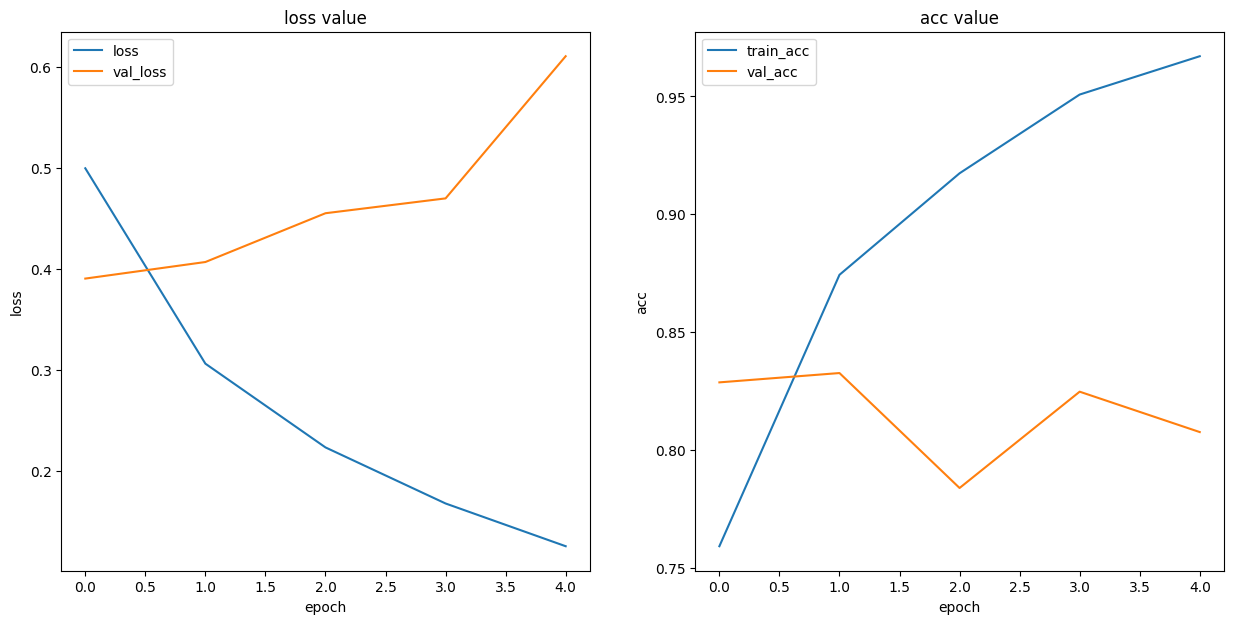

In [41]:
hist = pd.read_csv("./new_model/history/1st_train_history.csv")

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['epoch'], hist['loss'], label = "loss")
plt.plot(hist['epoch'], hist['val_loss'], label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("loss value")

plt.subplot(1, 2, 2)
plt.plot(hist['epoch'], hist['acc'], label = "train_acc")
plt.plot(hist['epoch'], hist['val_acc'], label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.title("acc value")

### Int Encoder 저장

차후에 모델을 저장해서 사용할 때 함께 필요한 요소이기에, pickle을 이용해서 저장한다.

In [42]:
import pickle

with open('./new_model/tokenizer/1st_tokenizer_title.pickle', 'wb') as file:
     pickle.dump(tokenizer_for_title, file)
     
with open('./new_model/tokenizer/1st_tokenizer_content.pickle', 'wb') as file:
     pickle.dump(tokenizer_for_content, file)

In [43]:
loaded_model = load_model('./new_model/model/multi_layer_128_64_32.h5')
print("테스트 정확도:", loaded_model.evaluate(X_test, y_test)[1])

24/24 [==============================] - 35s 1s/step - loss: 0.4069 - acc: 0.8327
테스트 정확도: 0.8326745629310608


In [44]:
def sentiment_predict(new_title, new_content):
    # 전처리
    new_title = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]', '', new_title)
    new_content = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-z ]', '', new_content)
    
    # 토큰화
    new_title = mecab.morphs(new_title)
    new_content = mecab.morphs(new_content)
    
    # 불용어 제거
    new_title = [word for word in new_title if not word in stopwords]
    new_content = [word for word in new_content if not word in stopwords]
    
    # 정수형 인코딩
    encoded_title = tokenizer_for_title.texts_to_sequences([new_title])
    encoded_content = tokenizer_for_content.texts_to_sequences([new_content])
    
    # 패딩
    padded_title = pad_sequences(encoded_title, maxlen = max_len_title)
    padded_content = pad_sequences(encoded_content, maxlen = max_len_content)
    
    # 결합
    new_data = np.concatenate((padded_title, padded_content), axis = 1)
    print(new_data.shape)
    
    score = float(loaded_model.predict(new_data, verbose=0)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 세상을 놀래킬 수 있겠군요 !".format(score * 100))
    else:
        print("{:.2f}% 확률로 인기를 얻기 어려울 것 같습니다. :(".format((1 - score) * 100))

In [45]:
sentiment_predict(
    '엔화를 너무 성급하게 환전했나봐요 ㅠㅠ', 
    '여행 계획 없을때 900원대로 떨어지길래 언젠가 가겠지 하고 \
    환전하고 여행일정 잡히고는 890원에 신난다고 환전해놨는데 더 떨어지고 \
    있네요 ㅠㅠ 900원대로 해놓은 엔화는 아까워서 못쓸거같아요 ㅋㅋㅋ \
    아무래도 집에 모셔놓고 1000원대로 올라가면 가져가서 써야겠어요 ㅋㅋㅋ')

(1, 1030)
80.65% 확률로 세상을 놀래킬 수 있겠군요 !


In [46]:
y_pred = []
for val in X_test:
    y_pred_val = loaded_model.predict(val.reshape(1, -1), verbose = 0)
    if y_pred_val > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [47]:
y_pred
X_test.shape
len(y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       376
           1       0.80      0.88      0.84       383

    accuracy                           0.83       759
   macro avg       0.84      0.83      0.83       759
weighted avg       0.84      0.83      0.83       759



In [1]:
import pandas as pd

df = pd.read_csv("./Merged_NewsResults.csv")
df

,제목,본문
0,음악으로 교감하는 싱글맘과 반항아 아들 영화 '플로라 앤 썬',아일랜드 더블린의 한 동네 클럽에서 열리는 아마추어 동네 음악 경연 대회. 이제 열...
1,오뚜기와 해태 설립의 '나비효과' 김치볶음밥의 탄생[책마을],프라이팬이 한국에 전해진 것은 일제강점기였지만 대중화된 것은 1970년대부터였다. ...
2,'수산물 소비' 식당 시장 희비에도 손님은 '불안불안',지금 당장은 괜찮을 것 같아 먹긴 하지만 불안이 가시진 않는다. 나중이 걱정이죠.일...
3,"수원 국회의원, 7개 공통 공약 중 3년간 3개 이행 [경기 인천 국회의원 공약 점검 ]","사진 왼쪽부터 김승원, 백혜련, 김영진, 박광온, 김진표 국회의원. 의원실 제공 ..."
4,"수원 미완 공약, 22대 국회로 넘어가나 [경기 인천 국회의원 공약 점검 ]",수원군공항 모습. 경기일보DB 수원특례시 국회의원들이 제시한 7대 공통 공약 중 ...
...,...,...
199065,"尹대통령, 한영 관계 최고 수준으로 격상시킨 '다우닝街 합의' 도출 예고",영국을 국빈 방문 중인 윤석열 대통령은 22일 열리는 리시 수낵 영국 총리와의 정상...
199066,청남대문의119안전센터 '합동소방훈련' 실시,KakaoTalk20231121170334699 청남대관리사업소는 21일 문의11...
199067,"에어프레미아, 블랙프라이데이 시즌 전 노선 특가 프로모션",에어프레미아Air Premia는 블랙프라이데이 시즌을 맞아 전 노선 특가프로모션을 ...
199068,"춘천YMCA, 지역 청소년들과 6.25참전 유공자회에 후원 물품 기탁",춘천YMCA가 지난 20일 대한민국 6.25참전 유공자회 춘천시지회에 후원 물품을 ...
